# Understanding the KC-MBON syanpse structure and its postsynaptic specificity

### Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from tqdm import tqdm
from functools import reduce

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
import scipy

In [5]:
import networkx as nx

In [6]:
label_fontsize = 16 
title_fontsize = 18

In [7]:
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

In [8]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

In [9]:
from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

In [10]:
import matplotlib.pyplot as plt

# This makes it so the PDF export works
import matplotlib as mpl
mpl.rcParams['pdf.use14corefonts']=True
mpl.rcParams['font.sans-serif'] = ['Helvetica',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Computer Modern Sans Serif',
                                   'Lucida Grande',
                                   'Verdana',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',                                          
                                   'Avant Garde',
                                   'sans-serif']
mpl.rcParams['font.size'] = 11

In [11]:
from matplotlib.colors import rgb2hex, to_rgb

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
figwidth_size = 5
figheigth_size = 5

In [14]:
#navis display options for frontal view..
elev = -180
azim = -90
dist = 6

In [15]:
# This is to get stuff from csvs in github..
import requests
import os
from io import StringIO

# Need to pass Github token -> private repository
token = os.environ['GITHUB_PAT']
session = requests.session()
headers={'Authorization': f'token {token}', 'Accept': 'application/vnd.github.v3.raw'}

def fetch_csv(url):
    """Fetch and parse csv from private repository."""
    response = session.get(url, headers=headers)
    data = StringIO(response.text)
    return pd.read_csv(data, index_col=0)

In [16]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [17]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/sri/Downloads/windy-raceway-269415-23746907ea2d.json', scope)
gc = gspread.authorize(credentials)

In [18]:
settings = fetch_csv('https://raw.githubusercontent.com/jagannathancolabs/2022_postsynapticplasticity/main/settings/color_maps.csv')
glob_colors = settings.hex.to_dict()
glob_colors = {c: to_rgb(v.strip()) for c, v in glob_colors.items()}

### Set configurations to fetch from data from neuprint

In [19]:
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1')

In [20]:
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

### Get KC neurons from hemibrain

In [21]:
kcneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^KC.*",regex=True)) #get some KC type neurons..

In [22]:
kcbodyidList = kcneurons_df[['bodyId']]

In [23]:
print('number of KC neurons: ', len(kcbodyidList))

number of KC neurons:  1927


In [24]:
kcneurons_df.type.unique()

array(['KCab-m', 'KCab-c', 'KCab-s', 'KCg-m', 'KCab-p', "KCa'b'-ap2",
       "KCa'b'-m", "KCa'b'-ap1", 'KCg-d', 'KCg-t', 'KCg-s4', 'KCg-s1',
       'KCg-s3', 'KCg-s2'], dtype=object)

In [25]:
mb_rois = ["b'L(L)", "b'L(R)", #betaprimelobe
           'bL(L)', 'bL(R)',   #betalobe
           'gL(L)', 'gL(R)',   #gammalobe
           "a'L(L)", "a'L(R)", #alphaprimelobe
           'aL(L)', 'aL(R)',   #alphalobe
          ]

### Get specificity within a synaptic set

In [26]:
def get_usablecks(targetmbon):
    #Identify the KCs that are actually connected to the specific type MBON..
    
    #Step1: fetch all the information about the specific type MBON..
    mbonneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type=targetmbon,regex=True))
    mbonbodyidList = mbonneurons_df[['bodyId']]
    
    print('number of mbon neurons of type --',targetmbon, '--: ', len(mbonbodyidList))
    
    #Step2: get the number of connections from all the KCs to the specific type MBON..
    neuron_df, conn_df = neu.queries.fetch_adjacencies(sources=kcbodyidList,targets=mbonbodyidList,rois = mb_rois)
    conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
    conn_df.drop(['instance_pre', 'instance_post'], inplace=True, axis=1)
    
    #Step3: identify only the KCs that are connected to the specific type MBON..
    usablekcbodyidList = conn_df.bodyId_pre.unique()
    
    print('number of kc neurons that are connected to target mbon: ', len(usablekcbodyidList))
    print('kc neuron types that are connected to target mbon: ', conn_df.type_pre.unique())
    #print('MBON neurons that are under investigation: ', conn_df.type_post.unique())
    
    
    #Step4: Just check if the number of inputs to the specific type MBON can be normalised..
    mbon_inputs = conn_df.groupby(['bodyId_pre','bodyId_post'], as_index=False)['weight'].sum()
    mbon_inputs['nSyn'] = mbon_inputs.index.map(lambda x: \
                                            (mbon_inputs.weight[x]/sum(mbon_inputs.weight[mbon_inputs.bodyId_post == mbon_inputs.bodyId_post[x]].values)))

    mbon_inputs['nSyn'] = 100*mbon_inputs['nSyn']
    
    usablembonbodyidList = conn_df.bodyId_post.unique()
    
    # check to see if normalisation happens wrt to the postsynapse
    norm_check = np.sum(mbon_inputs[mbon_inputs.bodyId_post == usablembonbodyidList[0]]['nSyn'])
    
    if np.round(norm_check) != 100:
        print('normalisation check: ', norm_check)
        
    
    print('connected to kcs: ', usablembonbodyidList)
    print('mbons not connected to kcs: ', list(set(mbonbodyidList['bodyId']) - set(usablembonbodyidList)))
    
    return usablekcbodyidList

In [27]:
def get_mbonspecificity(targetmbon, usablekcbodyidList):
    
    #Step1: identify the synaptic connections from the relevant KCs to all downstream neurons(including the specific type MBON)..
    synconn_df = fetch_synapse_connections(source_criteria=usablekcbodyidList,target_criteria=None,
                                           synapse_criteria=SC(rois=mb_rois, primary_only=True))
    
    kc_downstreamlist = [synconn_df.bodyId_pre.unique(), synconn_df.bodyId_post.unique()]
    kc_downstreamlist = list(itertools.chain(*kc_downstreamlist))
    
    print('candidate neurons downstream of KCs are: ', len(kc_downstreamlist))
    
    
    #Step2: get the properties of all the neurons downstream of KCs..
    kcdownstreamneurons_df, _ = neu.fetch_neurons(NC(bodyId = kc_downstreamlist))
    
    #print('candidate neuron types downstream of KCs are: ', len(kcdownstreamneurons_df.type.unique()))
    
    bodyidtype_map = dict(kcdownstreamneurons_df[['bodyId', 'type']].values)
    
    synconn_df['bodyId_pretype'] = synconn_df.bodyId_pre.map(bodyidtype_map)
    synconn_df['bodyId_posttype'] = synconn_df.bodyId_post.map(bodyidtype_map)
    
    
    #Step3: get a map of the presynaptic locations by the different types of neurons connected on the post-synpatic site..
    prepostsyn_df = synconn_df.copy()
    
    prepostsyn_df['presyn_loc'] = synconn_df['x_pre'].astype(str) + ',' + synconn_df['y_pre'].astype(str) + ',' + synconn_df['z_pre'].astype(str)
    prepostsyn_df['postsyn_loc'] = synconn_df['x_post'].astype(str) + ',' + synconn_df['y_post'].astype(str) + ',' + synconn_df['z_post'].astype(str)

    prepostsyn_df = prepostsyn_df.drop(columns=['x_pre','y_pre','z_pre',
                                                'x_post','y_post','z_post',
                                                'roi_pre','roi_post',
                                                'confidence_pre','confidence_post',])
    
    grouped_df = prepostsyn_df.groupby(['presyn_loc','bodyId_posttype']).size().reset_index()
    grouped_df.rename(columns={0:'count'}, inplace=True)
    grouped_df = grouped_df.set_index(['presyn_loc', 'bodyId_posttype'])
    
    
    #Step4: get a dataframe for each of the presynaptic locations (that contain target mbon) categorise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetmbon (count of postsynaptic neurons of target mbon)
    #MBONxx (count of postsynaptic neurons of any mbon, including target mbon)
    #total (total count of postsynaptic neurons of any type)
    #MBON_diff (MBONxx - targetmbon)
    cols = ['presyn_loc', targetmbon, 'MBONxx', 'total']
    tempsynconnlist = []
    for tempsynindex, tempsynconn_df in tqdm(grouped_df.groupby(level=0)):
        tempsynconn_df = tempsynconn_df.reset_index()
        if targetmbon in tempsynconn_df['bodyId_posttype'].values:
            tempsynconnlist.append([tempsynindex, tempsynconn_df[tempsynconn_df.bodyId_posttype == targetmbon]['count'].values[0], 
                                    np.sum(tempsynconn_df[tempsynconn_df['bodyId_posttype'].str.contains('MBON')]['count']),
                                    np.sum(tempsynconn_df['count'])])
            
    allsynconn_df = pd.DataFrame(tempsynconnlist, columns=cols)
    allsynconn_df['MBON_diff'] = allsynconn_df['MBONxx'] - allsynconn_df[targetmbon]
    
    totaltargetmbon_synapses = np.sum(allsynconn_df['MBON_diff'] >=0)
    
    
    #Step5: get a dataframe for the target mbon and summarise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetname (name of postsynaptic neurons of target mbon)
    #onlytargetmbon (count of postsynaptic sites containing only target mbon)
    #with1MBONxx (count of postsynaptic sites with MBON_diff == 1)
    #with2ormoreMBONxx (count of postsynaptic sites with MBON_diff >= 2)
    #overallsynapses (count of all postsynaptic sites)
    
    cols = ['targetname', 'onlytargetmbon', 'with1MBONxx', 'with2ormoreMBONxx', 'overallsynapticsites']
    
    mbonspecific_df = pd.DataFrame([[targetmbon,
                                     np.sum(allsynconn_df['MBON_diff'] == 0), 
                                     np.sum(allsynconn_df['MBON_diff'] == 1),
                                     np.sum(allsynconn_df['MBON_diff'] >= 2),
                                     np.sum(allsynconn_df['MBON_diff'] >=0)]],columns = cols)
    
    norm_mbonspecific_df = pd.DataFrame([[targetmbon,
                                         (np.sum(allsynconn_df['MBON_diff'] == 0))/totaltargetmbon_synapses, 
                                          (np.sum(allsynconn_df['MBON_diff'] == 1))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >= 2))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >=0))/totaltargetmbon_synapses]], columns=cols)

    
    return mbonspecific_df, norm_mbonspecific_df, grouped_df

In [28]:
allmbonList = ['MBON01', 'MBON02', 'MBON03',      'MBON04', 'MBON05', 
               'MBON06', 'MBON07', 'MBON09',      'MBON10', 'MBON11', 
               'MBON12', 'MBON13', 'MBON14',      'MBON15', 'MBON15-like', 
               'MBON16', 'MBON17', 'MBON17-like', 'MBON18', 'MBON19', 
               'MBON20', 'MBON21', 'MBON22',      'MBON23', 'MBON24', 
               'MBON25', 'MBON26', 'MBON27',      'MBON28', 'MBON29', 
               'MBON30', 'MBON31', 'MBON32',      'MBON33', 'MBON34',
               'MBON35']

In [29]:
len(allmbonList)

36

In [30]:
if os.path.exists('data/allmbonspecific.csv'):
    allmbonspecific_df = pd.read_csv('data/allmbonspecific.csv')
    allnorm_mbonspecific_df = pd.read_csv('data/allnorm_mbonspecific.csv')
else:
    allmbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])
    allnorm_mbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])

In [31]:
allmbonspecific_df.head()

,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,MBON01,21139,5270,424,26833
1,MBON02,13031,3384,57,16472
2,MBON03,10130,3128,246,13504
3,MBON04,2718,3331,432,6481
4,MBON05,13034,7173,929,21136


In [32]:
paper_mbons = ['MBON03','MBON16','MBON17','MBON17-like']

| em     | lm         | other   | 
|--------|------------|---------|
| MBON03 | MBON-β′2mp | MB-M4   |
| MBON16 | MBON-α′3ap | MB-V2α′ |
| MBON17 | MBON-α′3m  | MB-V2α′ |

In [33]:
allmbonspecific_df = allmbonspecific_df[~allmbonspecific_df['targetname'].isin(paper_mbons)]
allnorm_mbonspecific_df = allnorm_mbonspecific_df[~allnorm_mbonspecific_df['targetname'].isin(paper_mbons)]

In [34]:
synpasecount_cobodyids_df = pd.DataFrame([])

In [35]:
for targetmbonList in allmbonList:
    usablekcbodyidList = get_usablecks(targetmbonList)
    
    if targetmbonList in allmbonspecific_df.targetname.unique():
        print('skipping as ', targetmbonList, 'analysis already done')
        
    else:
        mbonspecific_df, norm_mbonspecific_df, grouped_df = get_mbonspecificity(targetmbonList, usablekcbodyidList)
    
        allmbonspecific_df = allmbonspecific_df.append(mbonspecific_df)
        allnorm_mbonspecific_df = allnorm_mbonspecific_df.append(norm_mbonspecific_df)
        
        #get dataframe for counting different neuron types that are along with the specific mbon type (co-bodyids)..
        locbytypecount_df = grouped_df.unstack()
        synapsecountbytype_df = locbytypecount_df.sum(axis=0)
        synapsecountbytype_df = synapsecountbytype_df.reset_index(level=[0,1])
        synapsecountbytype_df = synapsecountbytype_df.rename({'level_0': 'target_MBON', 'bodyId_posttype': 'co_bodyid_type', 0: 'synapse_count'}, axis=1) 
        synapsecountbytype_df['target_MBON'] = targetmbonList
        synpasecount_cobodyids_df = synpasecount_cobodyids_df.append(synapsecountbytype_df)
        
    
        #allmbonspecific_df.to_csv('data/allmbonspecific.csv', index=False)
        #allnorm_mbonspecific_df.to_csv('data/allnorm_mbonspecific.csv', index=False)

number of mbon neurons of type -- MBON01 --:  2


INFO - 2021-11-27 10:23:06,723 - utils - NumExpr defaulting to 8 threads.


number of kc neurons that are connected to target mbon:  984
kc neuron types that are connected to target mbon:  ['KCg-m' "KCa'b'-ap2" "KCa'b'-ap1" "KCa'b'-m" 'KCg-d' 'KCg-t' 'KCg-s1'
 'KCg-s3' 'KCg-s2']
connected to kcs:  [612371421 673509195]
mbons not connected to kcs:  []
skipping as  MBON01 analysis already done
number of mbon neurons of type -- MBON02 --:  2
number of kc neurons that are connected to target mbon:  1206
kc neuron types that are connected to target mbon:  ['KCab-m' 'KCab-c' 'KCab-s' 'KCg-m' 'KCab-p' "KCa'b'-ap2" "KCa'b'-m"
 "KCa'b'-ap1" 'KCg-d' 'KCg-s1' 'KCg-s2']
connected to kcs:  [ 424789697 5813022341]
mbons not connected to kcs:  []
skipping as  MBON02 analysis already done
number of mbon neurons of type -- MBON03 --:  2
number of kc neurons that are connected to target mbon:  344
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-m']
connected to kcs:  [487925037 612738462]
mbons not connected to kcs:  []


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  2078


100%|██████████| 76575/76575 [00:46<00:00, 1649.26it/s]


number of mbon neurons of type -- MBON04 --:  2
number of kc neurons that are connected to target mbon:  825
kc neuron types that are connected to target mbon:  ['KCg-m' "KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-t' 'KCg-d' 'KCg-s4'
 'KCg-s1' 'KCg-s3' 'KCg-s2']
connected to kcs:  [613079053 487925063]
mbons not connected to kcs:  []
skipping as  MBON04 analysis already done
number of mbon neurons of type -- MBON05 --:  2
number of kc neurons that are connected to target mbon:  783
kc neuron types that are connected to target mbon:  ['KCg-m' "KCa'b'-ap2" "KCa'b'-ap1" 'KCg-d' 'KCg-t' "KCa'b'-m" 'KCab-m'
 'KCg-s4' 'KCg-s1' 'KCg-s3' 'KCg-s2' 'KCab-s']
connected to kcs:  [799586652]
mbons not connected to kcs:  [1386512867]
skipping as  MBON05 analysis already done
number of mbon neurons of type -- MBON06 --:  2
number of kc neurons that are connected to target mbon:  1002
kc neuron types that are connected to target mbon:  ['KCab-m' 'KCab-c' 'KCab-s' 'KCg-m' 'KCab-p' "KCa'b'-m" "KCa'b'-ap2"

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  1669


100%|██████████| 73113/73113 [00:39<00:00, 1865.73it/s]


number of mbon neurons of type -- MBON17 --:  1
number of kc neurons that are connected to target mbon:  262
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCab-p']
connected to kcs:  [5812981264]
mbons not connected to kcs:  []


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  1331


100%|██████████| 57274/57274 [00:30<00:00, 1891.94it/s]


number of mbon neurons of type -- MBON17-like --:  1
number of kc neurons that are connected to target mbon:  268
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCab-p']
connected to kcs:  [5812981543]
mbons not connected to kcs:  []


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

candidate neurons downstream of KCs are:  1366


100%|██████████| 58686/58686 [00:30<00:00, 1950.65it/s]


number of mbon neurons of type -- MBON18 --:  2
number of kc neurons that are connected to target mbon:  880
kc neuron types that are connected to target mbon:  ['KCab-m' 'KCab-c' 'KCab-s' 'KCab-p' "KCa'b'-m"]
connected to kcs:  [5813020828]
mbons not connected to kcs:  [457196444]
skipping as  MBON18 analysis already done
number of mbon neurons of type -- MBON19 --:  2
number of kc neurons that are connected to target mbon:  394
kc neuron types that are connected to target mbon:  ['KCab-m' 'KCab-s' 'KCab-p' "KCa'b'-m" "KCa'b'-ap2"]
connected to kcs:  [423774471 517854468]
mbons not connected to kcs:  []
skipping as  MBON19 analysis already done
number of mbon neurons of type -- MBON20 --:  1
number of kc neurons that are connected to target mbon:  630
kc neuron types that are connected to target mbon:  ['KCg-m' "KCa'b'-ap1" 'KCg-d' 'KCg-t' 'KCg-s1' 'KCab-s' 'KCg-s2']
connected to kcs:  [792368888]
mbons not connected to kcs:  []
skipping as  MBON20 analysis already done
number of mbon

In [39]:
allmbonspecific_df = allmbonspecific_df.sort_values(by=['targetname'], ascending=True)
allmbonspecific_df = allmbonspecific_df.reset_index()
allmbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,0,MBON01,21139,5270,424,26833
1,1,MBON02,13031,3384,57,16472
2,0,MBON03,10130,3128,246,13504
3,3,MBON04,2718,3331,432,6481
4,4,MBON05,13034,7173,929,21136


In [40]:
allnorm_mbonspecific_df = allnorm_mbonspecific_df.sort_values(by=['targetname'], ascending=True)
allnorm_mbonspecific_df = allnorm_mbonspecific_df.reset_index()
allnorm_mbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,0,MBON01,0.787799,0.196400,0.015801,1.0
1,1,MBON02,0.791100,0.205440,0.003460,1.0
2,0,MBON03,0.750148,0.231635,0.018217,1.0
3,3,MBON04,0.419380,0.513964,0.066656,1.0
4,4,MBON05,0.616673,0.339374,0.043953,1.0


In [41]:
synpasecount_cobodyids_df

,target_MBON,co_bodyid_type,synapse_count
0,MBON03,5-HTPMPD01,1.0
1,MBON03,ALIN1,15.0
2,MBON03,AOTU008_a,6.0
3,MBON03,APL,17009.0
4,MBON03,ATL007,3.0
...,...,...,...
146,MBON17-like,SMP568_a,25.0
147,MBON17-like,TuBu10,1.0
148,MBON17-like,WEDPN4,6.0
149,MBON17-like,mAL6,5.0


In [42]:
#reshape dataframe so we have co_bodyid by specific mbon type, the values would be counts where they cooccur on the post-synaptic site..
cobodyid_by_mbontype_df = synpasecount_cobodyids_df.pivot(index = 'co_bodyid_type', columns='target_MBON',values='synapse_count')
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.reset_index()
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.set_index('co_bodyid_type')
cobodyid_by_mbontype_df

target_MBON,MBON03,MBON16,MBON17,MBON17-like
co_bodyid_type,,,,
5-HTPMPD01,1.0,1.0,1.0,1.0
ALIN1,15.0,13.0,15.0,16.0
AOTU008_a,6.0,6.0,NaN,NaN
APL,17009.0,16200.0,12178.0,12535.0
ATL007,3.0,3.0,2.0,2.0
...,...,...,...,...
TuBu10,1.0,NaN,1.0,1.0
VES079,1.0,1.0,NaN,NaN
WEDPN4,13.0,11.0,2.0,6.0


In [43]:
normcobodyid_by_mbontype_df = cobodyid_by_mbontype_df.copy()
cols = ['MBON03', 'MBON16', 'MBON17', 'MBON17-like']
normcobodyid_by_mbontype_df[cols] = 100*normcobodyid_by_mbontype_df[cols] / normcobodyid_by_mbontype_df[cols].sum()

In [44]:
normcobodyid_by_mbontype_df

target_MBON,MBON03,MBON16,MBON17,MBON17-like
co_bodyid_type,,,,
5-HTPMPD01,0.000399,0.000418,0.000535,0.000522
ALIN1,0.005987,0.005433,0.008031,0.008359
AOTU008_a,0.002395,0.002508,NaN,NaN
APL,6.789261,6.770594,6.519900,6.548941
ATL007,0.001197,0.001254,0.001071,0.001045
...,...,...,...,...
TuBu10,0.000399,NaN,0.000535,0.000522
VES079,0.000399,0.000418,NaN,NaN
WEDPN4,0.005189,0.004597,0.001071,0.003135


In [45]:
normcobodyid_by_mbontype_df['MBON03'].sum()

100.0

In [46]:
top_mbon03 = normcobodyid_by_mbontype_df.sort_values(by=['MBON03'], ascending=False)
top_mbon16 = normcobodyid_by_mbontype_df.sort_values(by=['MBON16'], ascending=False)
top_mbon17 = normcobodyid_by_mbontype_df.sort_values(by=['MBON17'], ascending=False)
top_mbon17like = normcobodyid_by_mbontype_df.sort_values(by=['MBON17-like'], ascending=False)

In [47]:
topneurontypes = reduce(np.union1d, (top_mbon03.index[0:9].values, top_mbon16.index[0:9].values, 
                    top_mbon17.index[0:9].values, top_mbon17like.index[0:9].values))

In [48]:
topneurontypes

array(['APL', 'DPM', "KCa'b'-ap1", "KCa'b'-ap2", "KCa'b'-m", 'MBON03',
       'MBON09', 'MBON13', 'PAM06_a'], dtype=object)

In [49]:
topneurontypes_dict = dict(zip(topneurontypes, topneurontypes))

In [50]:
topneurontypes_dict

{'APL': 'APL',
 'DPM': 'DPM',
 "KCa'b'-ap1": "KCa'b'-ap1",
 "KCa'b'-ap2": "KCa'b'-ap2",
 "KCa'b'-m": "KCa'b'-m",
 'MBON03': 'MBON03',
 'MBON09': 'MBON09',
 'MBON13': 'MBON13',
 'PAM06_a': 'PAM06_a'}

In [51]:
normcobodyid_by_mbontype_df.index = normcobodyid_by_mbontype_df.index.map(lambda x: topneurontypes_dict.get(x, 'Others'))

In [52]:
normcobodyid_by_mbontype_df

target_MBON,MBON03,MBON16,MBON17,MBON17-like
co_bodyid_type,,,,
Others,0.000399,0.000418,0.000535,0.000522
Others,0.005987,0.005433,0.008031,0.008359
Others,0.002395,0.002508,NaN,NaN
APL,6.789261,6.770594,6.519900,6.548941
Others,0.001197,0.001254,0.001071,0.001045
...,...,...,...,...
Others,0.000399,NaN,0.000535,0.000522
Others,0.000399,0.000418,NaN,NaN
Others,0.005189,0.004597,0.001071,0.003135


In [53]:
sorted_df = normcobodyid_by_mbontype_df.sort_values('MBON03', ascending = False)
sorted_df

target_MBON,MBON03,MBON16,MBON17,MBON17-like
co_bodyid_type,,,,
KCa'b'-ap2,14.760027,15.392653,19.146920,18.685510
KCa'b'-m,13.419259,13.242362,17.888769,17.564849
KCa'b'-ap1,9.584557,9.673173,2.837533,3.441394
DPM,7.801922,7.843023,7.825701,7.832606
APL,6.789261,6.770594,6.519900,6.548941
...,...,...,...,...
Others,0.000399,0.000418,0.000535,0.000522
Others,0.000399,0.000418,0.000535,0.000522
Others,0.000399,0.000418,0.000535,0.000522


In [54]:
sorted_df = sorted_df[sorted_df.index != 'Others']

In [55]:
sorted_df = sorted_df.append(pd.Series(100-sorted_df.sum(), name='others'))
sorted_df

target_MBON,MBON03,MBON16,MBON17,MBON17-like
co_bodyid_type,,,,
KCa'b'-ap2,14.760027,15.392653,19.146920,18.685510
KCa'b'-m,13.419259,13.242362,17.888769,17.564849
KCa'b'-ap1,9.584557,9.673173,2.837533,3.441394
DPM,7.801922,7.843023,7.825701,7.832606
APL,6.789261,6.770594,6.519900,6.548941
MBON03,5.453283,5.510093,6.155839,6.104856
MBON09,3.939679,3.931124,4.197942,4.160288
PAM06_a,3.036786,3.074769,3.820497,3.771061
MBON13,2.857166,2.910937,3.456436,3.409524


In [56]:
sorted_df['MBON03'].sum()

100.0

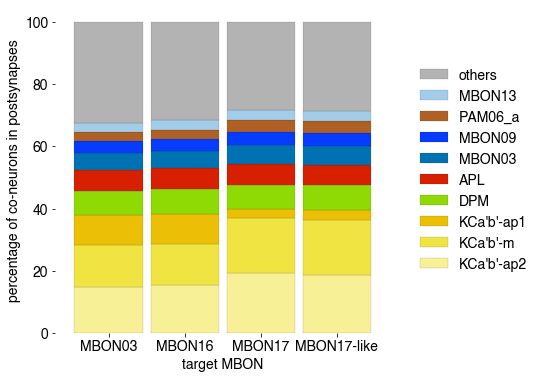

In [57]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])
ax = sorted_df.T.plot(kind='bar', stacked=True, ax = ax, color = glob_colors,
                     linewidth=0.1, width = 0.9, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.box(False)
ax.grid(False)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('target MBON',fontsize=label_fontsize-2, weight = 'bold')
ax.set_ylabel('percentage of co-neurons in postsynapses',fontsize=label_fontsize-2, weight = 'bold')
plt.savefig('figures/mbon_parsing_specificity.png', dpi=300, bbox_inches='tight')

In [58]:
allmbonspecific_df

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,0,MBON01,21139,5270,424,26833
1,1,MBON02,13031,3384,57,16472
2,0,MBON03,10130,3128,246,13504
3,3,MBON04,2718,3331,432,6481
4,4,MBON05,13034,7173,929,21136
5,5,MBON06,13708,1592,227,15527
6,6,MBON07,20861,596,25,21482
7,7,MBON09,20258,3752,252,24262
8,8,MBON10,354,679,115,1148
9,9,MBON11,11462,2072,218,13752


In [59]:
allnorm_mbonspecific_df['nontargetmbon'] = allnorm_mbonspecific_df['overallsynapticsites']  - allnorm_mbonspecific_df['onlytargetmbon'] 

In [60]:
allnorm_mbonspecific_df

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites,nontargetmbon
0,0,MBON01,0.787799,0.196400,0.015801,1.0,0.212201
1,1,MBON02,0.791100,0.205440,0.003460,1.0,0.208900
2,0,MBON03,0.750148,0.231635,0.018217,1.0,0.249852
3,3,MBON04,0.419380,0.513964,0.066656,1.0,0.580620
4,4,MBON05,0.616673,0.339374,0.043953,1.0,0.383327
5,5,MBON06,0.882849,0.102531,0.014620,1.0,0.117151
6,6,MBON07,0.971092,0.027744,0.001164,1.0,0.028908
7,7,MBON09,0.834968,0.154645,0.010387,1.0,0.165032
8,8,MBON10,0.308362,0.591463,0.100174,1.0,0.691638
9,9,MBON11,0.833479,0.150669,0.015852,1.0,0.166521


In [61]:
def repel_labels(ax, x, y, labels, selectedlabels = None, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        if label in selectedlabels:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',color='#053CFF',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='#D72000'), )
        else:
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='#D72000'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    #ax.set_xlim([mins[0], maxs[0]])
    #ax.set_ylim([mins[1], maxs[1]])

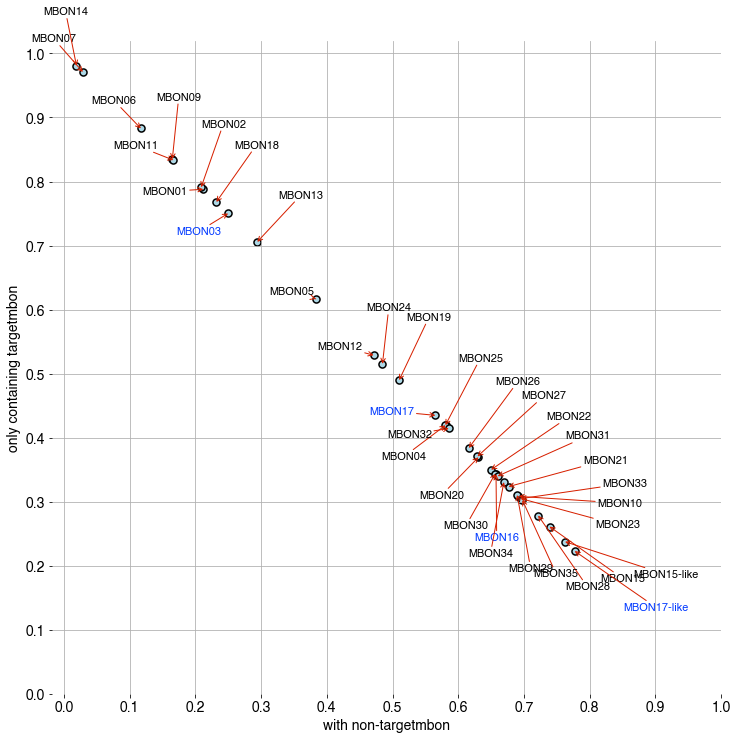

In [62]:
fig = plt.figure(figsize=(12, 12))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])

ax = sns.scatterplot('nontargetmbon', # Horizontal axis
                     'onlytargetmbon', # Vertical axis
                     data=allnorm_mbonspecific_df,
                     axes = ax,
                     color='#ADD8E6',
                     s=50,
                     linewidth = 1.5,
                     edgecolor='black') # size and dimension


# plotitems = ['MBON03', 'MBON16', 'MBON17']
plotitems = None

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xlabel('with non-targetmbon',fontsize=label_fontsize-2, weight = 'bold')
ax.set_ylabel('only containing targetmbon',fontsize=label_fontsize-2, weight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.box(False)
plt.grid(True)
sns.despine(trim=True)

repel_labels(ax = ax, x = allnorm_mbonspecific_df.nontargetmbon, y = allnorm_mbonspecific_df.onlytargetmbon, 
             labels = allnorm_mbonspecific_df.targetname, selectedlabels = paper_mbons, k = 0.04)

plt.savefig('figures/mbon_specificity.png', dpi=300, bbox_inches='tight')

In [63]:
paper_mbons

['MBON03', 'MBON16', 'MBON17', 'MBON17-like']

### Get specificity across synaptic sets

In [64]:
def get_closestdistance(targetmbon, usablekcbodyidList):
    
    #Step1: identify the synaptic connections from the specific type MBON to all upstream neurons including KCs..
    mbonsynconn_df = fetch_synapse_connections(source_criteria=None,target_criteria=targetmbon,
                                               synapse_criteria=SC(rois=mb_rois, primary_only=True))
    
    mbon_upstreamlist = [mbonsynconn_df.bodyId_pre.unique(), mbonsynconn_df.bodyId_post.unique()]
    mbon_upstreamlist = list(itertools.chain(*mbon_upstreamlist))
    
    print('candidate neurons upstream of ', targetmbon, 'are: ', len(mbon_upstreamlist))
    
    #Step2: get the properties of all the neurons upstream of mbons..
    mbonupstreamneurons_df, _ = neu.fetch_neurons(NC(bodyId = mbon_upstreamlist))
    #print('candidate neuron types upstream of MBONs are: ', len(mbonupstreamneurons_df.type.unique()))
    mbonupstreambodyidtype_map = dict(mbonupstreamneurons_df[['bodyId', 'type']].values)
    
    mbonsynconn_df['bodyId_pretype'] = mbonsynconn_df.bodyId_pre.map(mbonupstreambodyidtype_map)
    mbonsynconn_df['bodyId_posttype'] = mbonsynconn_df.bodyId_post.map(mbonupstreambodyidtype_map)
    
    #Step3: get a map of the postsynaptic locations by the different types of neurons connected on the pre-synpatic site..
    mbonprepostsyn_df = mbonsynconn_df.copy()
    mbonprepostsyn_df['presyn_loc'] = mbonsynconn_df['x_pre'].astype(str) + ',' + mbonsynconn_df['y_pre'].astype(str) + ',' + mbonsynconn_df['z_pre'].astype(str)
    mbonprepostsyn_df['postsyn_loc'] = mbonsynconn_df['x_post'].astype(str) + ',' + mbonsynconn_df['y_post'].astype(str) + ',' + mbonsynconn_df['z_post'].astype(str)
    mbonprepostsyn_df = mbonprepostsyn_df.drop(columns=['x_pre','y_pre','z_pre',
                                                        'x_post','y_post','z_post',
                                                        'roi_pre','roi_post',
                                                        'confidence_pre','confidence_post',])
    
    mbongrouped_df = mbonprepostsyn_df.groupby(['postsyn_loc','bodyId_pretype']).size().reset_index()
    mbongrouped_df.rename(columns={0:'count'}, inplace=True)
    mbongrouped_df = mbongrouped_df.set_index(['postsyn_loc', 'bodyId_pretype'])

    
    #Step4: prepare a dataframe of postsynaptic locations by the different types of neurons connected on the pre-synaptic site..
    postsynlocationsbypresyntype_df = mbongrouped_df.reset_index()
    postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']] = postsynlocationsbypresyntype_df['postsyn_loc'].str.split(',', expand=True)
    postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']] = postsynlocationsbypresyntype_df[['post_x', 'post_y', 'post_z']].astype(int)
    
#     #Step5: compute the euclidean distance between all pairs of postsynaptic locations..
#     distancemat = scipy.spatial.distance.cdist(postsynlocationsbypresyntype_df[['post_x','post_y','post_z']], 
#                                        postsynlocationsbypresyntype_df[['post_x','post_y','post_z']], metric='euclidean')
    
#     distance_df = pd.DataFrame(distancemat, index=postsynlocationsbypresyntype_df['postsyn_loc'], columns=postsynlocationsbypresyntype_df['postsyn_loc'])
    
#     closest_point = np.where(distance_df.eq(distance_df[distance_df != 0].min(),0),distance_df.columns,False)
#     closest_dist = np.where(distance_df.eq(distance_df[distance_df != 0].min(),0),distance_df.values,False)
    
#     # Remove false from the array and get the column names as list
#     postsynlocationsbypresyntype_df['closest_loc'] = [i[i.astype(bool)][0] for i in closest_point]
#     postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']] = postsynlocationsbypresyntype_df['closest_loc'].str.split(',', expand=True)
#     postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']] = postsynlocationsbypresyntype_df[['close_x', 'close_y', 'close_z']].astype(int)
    
#     postsynlocationsbypresyntype_df['closest_dist'] = [i[i.astype(bool)][0] for i in closest_dist]
    
#     # scale the voxel locations to raw nanometers
#     postsynlocationsbypresyntype_df['closest_dist_nm'] = (postsynlocationsbypresyntype_df['closest_dist']/125)*1000
    
#     euclideandistance_df = postsynlocationsbypresyntype_df[['bodyId_pretype', 'closest_dist_nm']]
#     euclideandistance_df['postsynaptictype'] = targetmbon

   
    postsynlocationsbykcpresyn_df = postsynlocationsbypresyntype_df[postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^KC.*)')==True]
    postsynlocationsbydanpresyn_df = postsynlocationsbypresyntype_df[((postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^PAM.*)')==True) |
                                                                      (postsynlocationsbypresyntype_df.bodyId_pretype.str.match(r'(^PPL.*)')==True))]
    
    
    #Step5: compute the euclidean distance between postsynaptic locations (which have kc as presynapse and dan as presynapse)..
    distancemat_kctodan = scipy.spatial.distance.cdist(postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], 
                                                       postsynlocationsbydanpresyn_df[['post_x','post_y','post_z']], metric='euclidean')
    
    distance_kctodan_df = pd.DataFrame(distancemat_kctodan, index=postsynlocationsbykcpresyn_df['postsyn_loc'], 
                                                            columns=postsynlocationsbydanpresyn_df['postsyn_loc'])
    
    postsynlocationsbykcpresyn_df['distance_kctodan'] = distance_kctodan_df.min(axis=1).values
    postsynlocationsbykcpresyn_df['closestpt_kctodan'] = distance_kctodan_df.idxmin(axis=1).values
    
    
    #Step6: compute the euclidean distance between postsynaptic locations (which have kc as presynapse and kc as presynapse)..
    distancemat_kctokc = scipy.spatial.distance.cdist(postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], 
                                                       postsynlocationsbykcpresyn_df[['post_x','post_y','post_z']], metric='euclidean')
    
    distance_kctokc_df = pd.DataFrame(distancemat_kctokc, index=postsynlocationsbykcpresyn_df['postsyn_loc'], 
                                                    columns=postsynlocationsbykcpresyn_df['postsyn_loc'])
    
    closest_point_kctokc = np.where(distance_kctokc_df.eq(distance_kctokc_df[distance_kctokc_df != 0].min(),0),distance_kctokc_df.columns,False)
    closest_dist_kctokc = np.where(distance_kctokc_df.eq(distance_kctokc_df[distance_kctokc_df != 0].min(),0),distance_kctokc_df.values,False)
    
    postsynlocationsbykcpresyn_df['distance_kctokc'] = [i[i.astype(bool)][0] for i in closest_dist_kctokc]
    postsynlocationsbykcpresyn_df['closestpt_kctokc'] = [i[i.astype(bool)][0] for i in closest_point_kctokc]
    
    
    #Step7: map a dataframe with the distances..
    postsynlocationsbykcpresyn_df['closestpttype_kctodan'] = postsynlocationsbykcpresyn_df['closestpt_kctodan'].map(postsynlocationsbypresyntype_df.set_index('postsyn_loc')['bodyId_pretype'])
    # scale the voxel locations to raw nanometers
    postsynlocationsbykcpresyn_df['distance_kctodan_nm'] = (postsynlocationsbykcpresyn_df['distance_kctodan']/125)*1000
    
    postsynlocationsbykcpresyn_df['closestpttype_kctokc'] = postsynlocationsbykcpresyn_df['closestpt_kctokc'].map(postsynlocationsbypresyntype_df.set_index('postsyn_loc')['bodyId_pretype'])
    postsynlocationsbykcpresyn_df['distance_kctokc_nm'] = (postsynlocationsbykcpresyn_df['distance_kctokc']/125)*1000
    
    plotsynlocationsdistance_df = postsynlocationsbykcpresyn_df[['postsyn_loc','bodyId_pretype','distance_kctodan_nm','distance_kctokc_nm']]
    statssynlocationsdistance_df = plotsynlocationsdistance_df.copy()
    statssynlocationsdistance_df['mbon_type'] = targetmbon
    
    plotsynlocationsdistance_df = plotsynlocationsdistance_df.melt(id_vars=["postsyn_loc", "bodyId_pretype"], var_name="type", value_name="distance")
    plotsynlocationsdistance_df['mbon_type'] = targetmbon
    
    return statssynlocationsdistance_df, plotsynlocationsdistance_df


In [65]:
allplotsynlocationsdistance_df = pd.DataFrame([])
allstatssynlocationsdistance_df = pd.DataFrame([])

In [66]:
for targetmbonList in paper_mbons:
    usablekcbodyidList = get_usablecks(targetmbonList)
    print('processing :', targetmbonList)
    statssynlocationsdistance_df, plotsynlocationsdistance_df = get_closestdistance(targetmbonList, usablekcbodyidList)
    allplotsynlocationsdistance_df = allplotsynlocationsdistance_df.append(plotsynlocationsdistance_df)
    allstatssynlocationsdistance_df = allstatssynlocationsdistance_df.append(statssynlocationsdistance_df)

number of mbon neurons of type -- MBON03 --:  2
number of kc neurons that are connected to target mbon:  344
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-m']
connected to kcs:  [487925037 612738462]
mbons not connected to kcs:  []
processing : MBON03


  0%|          | 0/89 [00:00<?, ?it/s]

candidate neurons upstream of  MBON03 are:  881
number of mbon neurons of type -- MBON16 --:  1
number of kc neurons that are connected to target mbon:  326
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCg-m']
connected to kcs:  [673366098]
mbons not connected to kcs:  []
processing : MBON16


  0%|          | 0/36 [00:00<?, ?it/s]

candidate neurons upstream of  MBON16 are:  355
number of mbon neurons of type -- MBON17 --:  1
number of kc neurons that are connected to target mbon:  262
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCab-p']
connected to kcs:  [5812981264]
mbons not connected to kcs:  []
processing : MBON17


  0%|          | 0/29 [00:00<?, ?it/s]

candidate neurons upstream of  MBON17 are:  285
number of mbon neurons of type -- MBON17-like --:  1
number of kc neurons that are connected to target mbon:  268
kc neuron types that are connected to target mbon:  ["KCa'b'-ap2" "KCa'b'-m" "KCa'b'-ap1" 'KCab-p']
connected to kcs:  [5812981543]
mbons not connected to kcs:  []
processing : MBON17-like


  0%|          | 0/29 [00:00<?, ?it/s]

candidate neurons upstream of  MBON17-like are:  287


In [67]:
import pingouin as pg
from pingouin import ttest

In [68]:
allstatssynlocationsdistance_df

,postsyn_loc,bodyId_pretype,distance_kctodan_nm,distance_kctokc_nm,mbon_type
0,"19964,30061,18945",KCa'b'-m,3128.951262,1113.150484,MBON03
1,"19980,29673,19260",KCa'b'-m,985.559739,187.445992,MBON03
2,"19984,29695,19253",KCa'b'-m,1090.643847,187.445992,MBON03
3,"19989,30105,18482",KCa'b'-ap2,3076.517512,1309.412082,MBON03
4,"20026,31155,18660",KCa'b'-ap1,1301.469938,1172.293479,MBON03
...,...,...,...,...,...
2341,"16873,29483,11103",KCa'b'-m,933.123786,693.235891,MBON17-like
2342,"16882,27318,7683",KCa'b'-m,122.114700,605.785441,MBON17-like
2345,"16920,27214,7190",KCab-p,599.946664,587.496383,MBON17-like
2346,"16920,27287,7198",KCa'b'-m,36.660606,587.496383,MBON17-like


In [69]:
res_mbon03 = ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON03')]['distance_kctodan_nm'], 
                   allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON03')]['distance_kctokc_nm'], 
                   paired=True).round(3)

/opt/anaconda3/lib/python3.8/site-packages/pingouin/bayesian.py:146: RuntimeWarning:

divide by zero encountered in double_scalars



In [70]:
res_mbon03

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,93.27,13661,two-sided,0.0,"[534.51, 557.46]",1.063,inf,1.0


In [71]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON16')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON16')]['distance_kctokc_nm'], 
      paired=True).round(3)

/opt/anaconda3/lib/python3.8/site-packages/pingouin/bayesian.py:146: RuntimeWarning:

divide by zero encountered in double_scalars



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,88.453,4638,two-sided,0.0,"[809.14, 845.83]",1.801,inf,1.0


In [72]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17')]['distance_kctokc_nm'], 
      paired=True).round(3)

/opt/anaconda3/lib/python3.8/site-packages/pingouin/bayesian.py:146: RuntimeWarning:

divide by zero encountered in double_scalars



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,78.691,2791,two-sided,0.0,"[1131.41, 1189.23]",2.083,inf,1.0


In [73]:
ttest(allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17-like')]['distance_kctodan_nm'], 
      allstatssynlocationsdistance_df[(allstatssynlocationsdistance_df['mbon_type'] == 'MBON17-like')]['distance_kctokc_nm'], 
      paired=True).round(3)

/opt/anaconda3/lib/python3.8/site-packages/pingouin/bayesian.py:146: RuntimeWarning:

divide by zero encountered in double_scalars



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,67.261,2157,two-sided,0.0,"[1676.74, 1777.45]",2.013,inf,1.0


In [74]:
distance_cmap = {
    'distance_kctodan_nm': (0.6862745098039216, 0.3803921568627451, 0.1450980392156863), #'PAM06_a'
    'distance_kctokc_nm': (0.9411764705882353, 0.8941176470588236, 0.25882352941176473)  #'KCa'b'-m'
}

In [75]:
def statannotation(ax, x1, x2, y,text):
    h = 100
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

In [76]:
# fig = plt.figure(figsize=(6, 6))
# gs_main = gridspec.GridSpec(1, 1)
# gs_main.update(wspace=0, hspace=0)

# #set up the legend..
# gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
# ax = fig.add_subplot(gs[0])

# ax = sns.boxplot(x="mbon_type", y="distance", hue="type", data=allplotsynlocationsdistance_df, showfliers = False, palette=distance_cmap)

# # string_val = 't(' + str(np.round(res_mbon03['dof'].values[0],2)) + ')= ' + str(np.round(res_mbon03['T'].values[0],2)) + ', p' + ' <0.001***'+ \
# #               "\nCohens'd: " + str(np.round(res_mbon03['cohen-d'].values[0],2))

# string_val = 'p' + ' <0.001***'
# statannotation(ax = ax, x1 = -0.25, x2 = 0.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 1-0.25, x2 = 1.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 2-0.25, x2 = 2.25, y = 5000, text = string_val)

# statannotation(ax = ax, x1 = 3-0.25, x2 = 3.25, y = 5000, text = string_val)

# handles, labels = ax.get_legend_handles_labels()
# labels = ['kc to dan', 'kc to kc']
# ax.legend(handles, labels, loc='center left', 
#           bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

# ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
# plt.box(False)
# ax.grid(True)
# ax.set_ylabel('closest distance (nm)',fontsize=label_fontsize-2, weight = 'bold')
# ax.set_xlabel('\nMBON type',fontsize=label_fontsize-2, weight = 'bold')
# plt.savefig('figures/postsynapse_mbon_specificity.png', dpi=300, bbox_inches='tight')

In [77]:
onlykctokcplotdistance_df = allplotsynlocationsdistance_df[allplotsynlocationsdistance_df['type'] == 'distance_kctokc_nm']
onlykctokcplotdistance_df

,postsyn_loc,bodyId_pretype,type,distance,mbon_type
13662,"19964,30061,18945",KCa'b'-m,distance_kctokc_nm,1113.150484,MBON03
13663,"19980,29673,19260",KCa'b'-m,distance_kctokc_nm,187.445992,MBON03
13664,"19984,29695,19253",KCa'b'-m,distance_kctokc_nm,187.445992,MBON03
13665,"19989,30105,18482",KCa'b'-ap2,distance_kctokc_nm,1309.412082,MBON03
13666,"20026,31155,18660",KCa'b'-ap1,distance_kctokc_nm,1172.293479,MBON03
...,...,...,...,...,...
4311,"16873,29483,11103",KCa'b'-m,distance_kctokc_nm,693.235891,MBON17-like
4312,"16882,27318,7683",KCa'b'-m,distance_kctokc_nm,605.785441,MBON17-like
4313,"16920,27214,7190",KCab-p,distance_kctokc_nm,587.496383,MBON17-like
4314,"16920,27287,7198",KCa'b'-m,distance_kctokc_nm,587.496383,MBON17-like


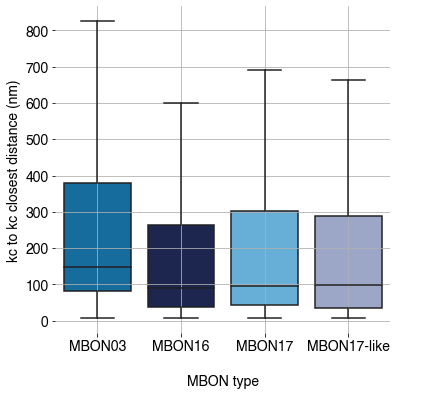

In [78]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])

ax = sns.boxplot(x=onlykctokcplotdistance_df['mbon_type'],
                 y=onlykctokcplotdistance_df['distance'], showfliers = False, palette = glob_colors)

handles, labels = ax.get_legend_handles_labels()
labels = ['kc to kc']
ax.legend(handles, labels, loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize-2},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.box(False)
ax.grid(True)
ax.set_ylabel('kc to kc closest distance (nm)',fontsize=label_fontsize-2, weight = 'bold')
ax.set_xlabel('\nMBON type',fontsize=label_fontsize-2, weight = 'bold')
plt.savefig('figures/postsynapse_mbon_specificity.png', dpi=300, bbox_inches='tight')